In [1]:
############################################ STEP1: IMPORTING PACKAGES ######################################################
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
import os 
import sys
import random
from tqdm import tqdm
from keras.models import Model, load_model
from keras.layers import Input, Dense, MaxPooling2D
from keras.layers.core import Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K
from keras import optimizers
import tensorflow as tf

np.random.seed = 1337

# setting training and validation images and mask paths
TRAIN_IMG_PATH = 'training_images/training_images'
VAL_IMG_PATH = 'validation_images/validation_images'
TEST_IMG_PATH = 'testing_images/testing_images'
TRAIN_MASK_PATH = 'training_masks/training_masks'
VAL_MASK_PATH= 'validation_masks/validation_masks'

# setting image width and height and setting as RGB channel
IMG_WIDTH = 128 
IMG_HEIGHT = 128 
IMG_CHANNELS = 3

# Getting list of training and testing images in an array
train_ids = next(os.walk(TRAIN_IMG_PATH))[2]
test_ids = next(os.walk(TEST_IMG_PATH))[2]
train_masks = next(os.walk(TRAIN_MASK_PATH))[2]
val_ids = next(os.walk(VAL_IMG_PATH))[2]
val_masks= next(os.walk(VAL_MASK_PATH))[2]

print('Done with initializations..!!')

H:\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


Done with initializations..!!


In [4]:
######################################### STEP2: RESIZING IMAGES ###########################################################
# Resizing training images
X_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
print('Getting and resizing training images ... ')
sys.stdout.flush()
for n, id_ in tqdm(enumerate(train_ids), total=len(train_ids)):
    path = TRAIN_IMG_PATH + '/' + id_
    img = imread(path)[:,:,:IMG_CHANNELS]
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_train[n] = img

# Resizing training mask images
Y_train = np.zeros((len(train_masks), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
print('Getting and resizing training masks ... ')
sys.stdout.flush()
for n, id_ in tqdm(enumerate(train_masks), total=len(train_masks)):
    path = TRAIN_MASK_PATH + '/' + id_
    mask = imread(path)[:,:]
    mask = np.expand_dims(mask, axis=-1)
    mask = resize(mask, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    Y_train[n] = mask
##################################################################################################
# Resizing validation images
X_Val = np.zeros((len(val_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
print('Getting and resizing validation images ... ')
sys.stdout.flush()
for n, id_ in tqdm(enumerate(val_ids), total=len(val_ids)):
    path = VAL_IMG_PATH + '/' + id_
    img = imread(path)[:,:,:IMG_CHANNELS]
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_Val[n] = img

# Resizing training mask images
Y_Val = np.zeros((len(val_masks), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
print('Getting and resizing training masks ... ')
sys.stdout.flush()
for n, id_ in tqdm(enumerate(val_masks), total=len(val_masks)):
    path = VAL_MASK_PATH + '/' + id_
    mask = imread(path)[:,:]
    mask = np.expand_dims(mask, axis=-1)
    mask = resize(mask, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    Y_Val[n] = mask

###########################################################################################
    
# Resizing test images
X_test = np.zeros((len(test_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
sizes_test = []
print('Getting and resizing test images ... ')
sys.stdout.flush()
for n, id_ in tqdm(enumerate(test_ids), total=len(test_ids)):
    path = TEST_IMG_PATH + '/' + id_
    img = imread(path)[:,:,:IMG_CHANNELS]
    sizes_test.append([img.shape[0], img.shape[1]])
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_test[n] = img

print('Done!')

Getting and resizing training images ... 


100%|██████████████████████████████████████████████████████████████████████████████| 1500/1500 [00:24<00:00, 61.44it/s]


Getting and resizing training masks ... 


100%|██████████████████████████████████████████████████████████████████████████████| 1500/1500 [00:18<00:00, 83.16it/s]


Getting and resizing validation images ... 


100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [00:07<00:00, 70.91it/s]


Getting and resizing training masks ... 


100%|███████████████████████████████████████████████████████████████████████████████| 500/500 [00:04<00:00, 110.54it/s]


Getting and resizing test images ... 


100%|████████████████████████████████████████████████████████████████████████████████| 927/927 [00:12<00:00, 71.97it/s]


Done!


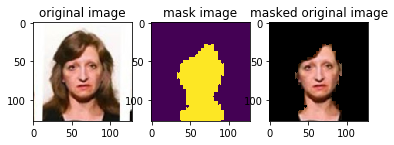

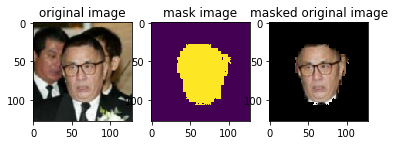

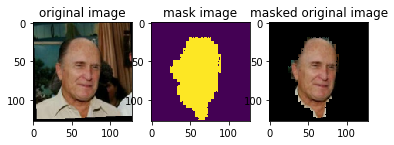

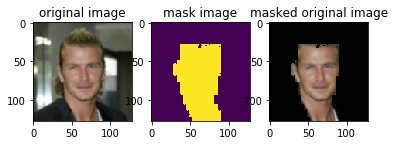

In [5]:
############################################## STEP3: PLOTTING SAMPLE IMAGES #################################################
# Checking if training and mask data looks right
for ix in np.arange(4):
    #Removing single-dimensional entries into 2D for mask to be plot
    mask = np.squeeze(Y_train[ix])
    # Create a masked image copy
    masked = np.copy(X_train[ix]) * Y_train[ix]
    # Display original, mask, and masked images side-by-side
    f, (ax0, ax1, ax2) = plt.subplots(1, 3)
    ax0.set_title('original image')
    ax0.imshow(X_train[ix])
    ax1.set_title('mask image')
    ax1.imshow(mask)
    ax2.set_title('masked original image')
    ax2.imshow(masked)
    plt.show()

In [12]:
############################################## STEP4: FUNCTIONS ###############################################################
from keras.layers import BatchNormalization
from keras.losses import binary_crossentropy
from keras.callbacks import EarlyStopping, ModelCheckpoint,ReduceLROnPlateau
#function to calculate DICE coefficient
# formula: 2∗|X∩Y|/|X|+|Y|
def dice_coeff(y_true, y_pred):
    smooth = 1.
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
#vbinary crossentropy dice loss
def bce_dice_loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) + (1 - dice_coeff(y_true, y_pred))


# Defining U-Net neural network model
def unet(height, width, num_channels):
    inputs = Input((height, width, num_channels))
    inputs_ = Lambda(lambda x: x / 255) (inputs)

    conv2 = Conv2D(16, (3, 3), activation='relu', padding='same', name='conv2_1') (inputs_)
    conv2=BatchNormalization()(conv2)
    conv2 = Conv2D(16, (3, 3), activation='relu', padding='same', name='conv2_2') (conv2)
    conv2=BatchNormalization()(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2), name='pool2') (conv2)

    conv3 = Conv2D(32, (3, 3), activation='relu', padding='same', name='conv3_1') (pool2)
    conv3=BatchNormalization()(conv3)
    conv3 = Conv2D(32, (3, 3), activation='relu', padding='same', name='conv3_2') (conv3)
    conv3=BatchNormalization()(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2), name='pool3') (conv3)

    conv4 = Conv2D(64, (3, 3), activation='relu', padding='same', name='conv4_1') (pool3)
    conv4=BatchNormalization()(conv4)
    conv4 = Conv2D(64, (3, 3), activation='relu', padding='same', name='conv4_2') (conv4)
    conv4=BatchNormalization()(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2), name='pool4') (conv4)

    conv5 = Conv2D(128, (3, 3), activation='relu', padding='same', name='conv5_1') (pool4)
    conv5=BatchNormalization()(conv5)
    conv5 = Conv2D(128, (3, 3), activation='relu', padding='same', name='conv5_2') (conv5)
    conv5=BatchNormalization()(conv5)
    pool5 = MaxPooling2D(pool_size=(2, 2), name='pool5') (conv5)

    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same', name='conv6_1') (pool5)
    conv6=BatchNormalization()(conv6)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same', name='conv6_2') (conv6)
    conv6=BatchNormalization()(conv6)
    pool6 = MaxPooling2D(pool_size=(2, 2), name='pool6') (conv6)
    
    conv7 = Conv2D(512, (3, 3), activation='relu', padding='same', name='conv7_1') (pool6)
    conv7=BatchNormalization()(conv7)
    conv7 = Conv2D(512, (3, 3), activation='relu', padding='same', name='conv7_2') (conv7)
    conv7=BatchNormalization()(conv7)
    
    up8 = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same') (conv7)
    up8 = concatenate([up8, conv6], axis=3)
    conv8 = Conv2D(256, (3, 3), activation='relu', padding='same', name='conv8_1') (up8)
    conv8=BatchNormalization()(conv8)
    conv8 = Conv2D(256, (3, 3), activation='relu', padding='same', name='conv8_2') (conv8)
    conv8=BatchNormalization()(conv8)

    up9 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same') (conv8)
    up9 = concatenate([up9, conv5], axis=3)
    conv9 = Conv2D(128, (3, 3), activation='relu', padding='same', name='conv9_1') (up9)
    conv9=BatchNormalization()(conv9)
    conv9 = Conv2D(128, (3, 3), activation='relu', padding='same', name='conv9_2') (conv9)
    conv9=BatchNormalization()(conv9)

    up10 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (conv9)
    up10 = concatenate([up10, conv4], axis=3)
    conv10 = Conv2D(64, (3, 3), activation='relu', padding='same', name='conv10_1') (up10)
    conv10=BatchNormalization()(conv10)
    conv10 = Conv2D(64, (3, 3), activation='relu', padding='same', name='conv10_2') (conv10)
    conv10=BatchNormalization()(conv10)

    up11 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (conv10)
    up11 = concatenate([up11, conv3], axis=3)
    conv11 = Conv2D(32, (3, 3), activation='relu', padding='same', name='conv11_1') (up11)
    conv11=BatchNormalization()(conv11)
    conv11 = Conv2D(32, (3, 3), activation='relu', padding='same', name='conv11_2') (conv11)
    conv11=BatchNormalization()(conv11)
    
    up12 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (conv11)
    up12 = concatenate([up12, conv2], axis=3)
    conv12 = Conv2D(16, (3, 3), activation='relu', padding='same', name='conv12_1') (up12)
    conv12=BatchNormalization()(conv12)
    conv12 = Conv2D(16, (3, 3), activation='relu', padding='same', name='conv12_2') (conv12)
    conv12=BatchNormalization()(conv12)
    
    outputs = Conv2D(1, (1, 1), activation='sigmoid') (conv12)

    model = Model(inputs=[inputs], outputs=[outputs])
    return model

######################################### STEP5: BUILDING, FITTING MODEL ######################################################
print('========================================================================================')
print('Creating and compiling model...')
model = unet(IMG_WIDTH, IMG_HEIGHT, IMG_CHANNELS)
# Using adam as optimizer
adam = optimizers.Adam(lr=0.001, decay =0.0) 
# compiling model
model.compile(optimizer=adam, loss=bce_dice_loss, metrics=[dice_coeff])
print('========================================================================================')
print('Fitting model...')
# Defining early stopping callback and saving best weights
callbacksDef = [EarlyStopping(monitor='val_dice_coeff',
                           patience=7,
                           verbose=1,
                           min_delta=1e-4,
                           mode='max'),
             ReduceLROnPlateau(monitor='val_dice_coeff',
                               factor=0.5,
                               patience=4,
                               verbose=1,
                               epsilon=1e-4,
                               mode='max'),
             ModelCheckpoint(monitor='val_dice_coeff',
                             filepath='skin_weights2.h5',
                             save_best_only=True,
                             save_weights_only=True,
                             mode='max')]

#fitting model
results = model.fit(X_train, Y_train, validation_data=(X_Val,Y_Val), batch_size=32, epochs=25, verbose=1,
                    callbacks=callbacksDef) 

######################################### STEP6: PREDICTING TESTING DATA#######################################################
print('========================================================================================')
print('========================================================================================')
print('Predicting on train, val and test...')
preds_train = model.predict(X_train[:int(X_train.shape[0]*0.9)], verbose=1)
preds_val = model.predict(X_train[int(X_train.shape[0]*0.9):], verbose=1)
preds_test = model.predict(X_test, verbose=1)

# Thresholding predictions
preds_train_t = (preds_train > 0.25).astype(np.uint8)
preds_val_t = (preds_val > 0.25).astype(np.uint8)
preds_test_t = (preds_test > 0.25).astype(np.uint8)

# Creating list of upsampled test masks
preds_test_upsampled = []
for i in range(len(preds_test)):
    preds_test_upsampled.append(resize(np.squeeze(preds_test[i]), 
                                       (sizes_test[i][0], sizes_test[i][1]), 
                                       mode='constant', preserve_range=True))

print('done with prediction..')

Creating and compiling model...
Fitting model...


H:\Anaconda3\lib\site-packages\keras\callbacks.py:928: UserWarning: `epsilon` argument is deprecated and will be removed, use `min_delta` insted.
  warnings.warn('`epsilon` argument is deprecated and '


Train on 1500 samples, validate on 500 samples
Epoch 1/25
1500/1500 [==============================] - ETA: 20:46 - loss: 1.4973 - dice_coeff: 0.336 - ETA: 17:29 - loss: 1.4294 - dice_coeff: 0.362 - ETA: 15:48 - loss: 1.3730 - dice_coeff: 0.384 - ETA: 14:46 - loss: 1.3234 - dice_coeff: 0.405 - ETA: 14:20 - loss: 1.2813 - dice_coeff: 0.422 - ETA: 14:05 - loss: 1.2323 - dice_coeff: 0.441 - ETA: 13:30 - loss: 1.1935 - dice_coeff: 0.455 - ETA: 12:58 - loss: 1.1458 - dice_coeff: 0.474 - ETA: 12:28 - loss: 1.1046 - dice_coeff: 0.490 - ETA: 12:02 - loss: 1.0652 - dice_coeff: 0.505 - ETA: 11:37 - loss: 1.0307 - dice_coeff: 0.518 - ETA: 11:13 - loss: 1.0004 - dice_coeff: 0.530 - ETA: 10:50 - loss: 0.9727 - dice_coeff: 0.542 - ETA: 10:28 - loss: 0.9461 - dice_coeff: 0.554 - ETA: 10:06 - loss: 0.9212 - dice_coeff: 0.564 - ETA: 9:44 - loss: 0.9019 - dice_coeff: 0.572 - ETA: 9:24 - loss: 0.8815 - dice_coeff: 0.58 - ETA: 9:03 - loss: 0.8639 - dice_coeff: 0.58 - ETA: 8:43 - loss: 0.8473 - dice_coeff:

1500/1500 [==============================] - ETA: 13:38 - loss: 0.1584 - dice_coeff: 0.924 - ETA: 13:31 - loss: 0.1669 - dice_coeff: 0.921 - ETA: 13:11 - loss: 0.1728 - dice_coeff: 0.918 - ETA: 12:51 - loss: 0.1684 - dice_coeff: 0.919 - ETA: 12:31 - loss: 0.1665 - dice_coeff: 0.920 - ETA: 12:11 - loss: 0.1640 - dice_coeff: 0.921 - ETA: 11:56 - loss: 0.1659 - dice_coeff: 0.920 - ETA: 11:37 - loss: 0.1632 - dice_coeff: 0.921 - ETA: 11:18 - loss: 0.1634 - dice_coeff: 0.921 - ETA: 11:00 - loss: 0.1653 - dice_coeff: 0.920 - ETA: 10:41 - loss: 0.1634 - dice_coeff: 0.921 - ETA: 10:23 - loss: 0.1622 - dice_coeff: 0.921 - ETA: 10:05 - loss: 0.1612 - dice_coeff: 0.922 - ETA: 9:48 - loss: 0.1603 - dice_coeff: 0.922 - ETA: 9:30 - loss: 0.1617 - dice_coeff: 0.92 - ETA: 9:12 - loss: 0.1599 - dice_coeff: 0.92 - ETA: 8:54 - loss: 0.1596 - dice_coeff: 0.92 - ETA: 8:37 - loss: 0.1592 - dice_coeff: 0.92 - ETA: 8:19 - loss: 0.1584 - dice_coeff: 0.92 - ETA: 8:01 - loss: 0.1590 - dice_coeff: 0.92 - ETA: 7:4

1500/1500 [==============================] - ETA: 13:43 - loss: 0.1069 - dice_coeff: 0.947 - ETA: 13:21 - loss: 0.1106 - dice_coeff: 0.945 - ETA: 13:02 - loss: 0.1163 - dice_coeff: 0.943 - ETA: 12:49 - loss: 0.1189 - dice_coeff: 0.942 - ETA: 12:30 - loss: 0.1185 - dice_coeff: 0.943 - ETA: 12:13 - loss: 0.1182 - dice_coeff: 0.943 - ETA: 11:55 - loss: 0.1176 - dice_coeff: 0.943 - ETA: 11:37 - loss: 0.1190 - dice_coeff: 0.943 - ETA: 11:19 - loss: 0.1176 - dice_coeff: 0.944 - ETA: 11:01 - loss: 0.1160 - dice_coeff: 0.944 - ETA: 10:43 - loss: 0.1161 - dice_coeff: 0.945 - ETA: 10:25 - loss: 0.1167 - dice_coeff: 0.944 - ETA: 10:06 - loss: 0.1180 - dice_coeff: 0.944 - ETA: 9:49 - loss: 0.1182 - dice_coeff: 0.944 - ETA: 9:31 - loss: 0.1189 - dice_coeff: 0.94 - ETA: 9:14 - loss: 0.1190 - dice_coeff: 0.94 - ETA: 8:56 - loss: 0.1192 - dice_coeff: 0.94 - ETA: 8:38 - loss: 0.1195 - dice_coeff: 0.94 - ETA: 8:20 - loss: 0.1199 - dice_coeff: 0.94 - ETA: 8:02 - loss: 0.1196 - dice_coeff: 0.94 - ETA: 7:4

1500/1500 [==============================] - ETA: 15:52 - loss: 0.0928 - dice_coeff: 0.955 - ETA: 15:14 - loss: 0.0966 - dice_coeff: 0.954 - ETA: 14:41 - loss: 0.0966 - dice_coeff: 0.954 - ETA: 14:08 - loss: 0.0940 - dice_coeff: 0.955 - ETA: 13:52 - loss: 0.0940 - dice_coeff: 0.955 - ETA: 13:29 - loss: 0.0923 - dice_coeff: 0.956 - ETA: 13:08 - loss: 0.0920 - dice_coeff: 0.956 - ETA: 12:51 - loss: 0.0927 - dice_coeff: 0.956 - ETA: 12:33 - loss: 0.0917 - dice_coeff: 0.956 - ETA: 12:12 - loss: 0.0920 - dice_coeff: 0.956 - ETA: 11:53 - loss: 0.0919 - dice_coeff: 0.956 - ETA: 11:33 - loss: 0.0920 - dice_coeff: 0.956 - ETA: 11:15 - loss: 0.0916 - dice_coeff: 0.956 - ETA: 10:57 - loss: 0.0917 - dice_coeff: 0.956 - ETA: 10:38 - loss: 0.0916 - dice_coeff: 0.956 - ETA: 10:20 - loss: 0.0909 - dice_coeff: 0.957 - ETA: 10:03 - loss: 0.0912 - dice_coeff: 0.957 - ETA: 9:44 - loss: 0.0910 - dice_coeff: 0.957 - ETA: 9:26 - loss: 0.0911 - dice_coeff: 0.95 - ETA: 9:05 - loss: 0.0917 - dice_coeff: 0.95 - 

1500/1500 [==============================] - ETA: 14:02 - loss: 0.0762 - dice_coeff: 0.963 - ETA: 13:39 - loss: 0.0776 - dice_coeff: 0.963 - ETA: 13:28 - loss: 0.0779 - dice_coeff: 0.963 - ETA: 13:09 - loss: 0.0787 - dice_coeff: 0.963 - ETA: 12:55 - loss: 0.0779 - dice_coeff: 0.963 - ETA: 12:34 - loss: 0.0774 - dice_coeff: 0.963 - ETA: 12:14 - loss: 0.0781 - dice_coeff: 0.963 - ETA: 11:59 - loss: 0.0781 - dice_coeff: 0.963 - ETA: 11:41 - loss: 0.0780 - dice_coeff: 0.963 - ETA: 11:20 - loss: 0.0776 - dice_coeff: 0.963 - ETA: 11:01 - loss: 0.0768 - dice_coeff: 0.964 - ETA: 10:42 - loss: 0.0767 - dice_coeff: 0.964 - ETA: 10:23 - loss: 0.0766 - dice_coeff: 0.964 - ETA: 10:04 - loss: 0.0769 - dice_coeff: 0.964 - ETA: 9:45 - loss: 0.0765 - dice_coeff: 0.964 - ETA: 9:26 - loss: 0.0763 - dice_coeff: 0.96 - ETA: 9:09 - loss: 0.0763 - dice_coeff: 0.96 - ETA: 8:51 - loss: 0.0762 - dice_coeff: 0.96 - ETA: 8:33 - loss: 0.0764 - dice_coeff: 0.96 - ETA: 8:14 - loss: 0.0765 - dice_coeff: 0.96 - ETA: 7

In [13]:
######################################### STEP7: SAVING MASKS TO A DIRECTORY ###################################################
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
from skimage.transform import resize
from skimage.io import imread
from scipy.misc import imread, imresize, imsave
%matplotlib inline  

# Renaming file name for submission file
test_ids_ = list(map(lambda x:x.replace('img','mask'),test_ids)) 
# Upsampling and shaping all test-prediction masks and saving to a directory
for i in np.arange(len(preds_test_t)):
    mask_ = np.squeeze(preds_test_t[i])
    mask_ = np.array(mask_*255, dtype='uint8')
    mask_ = imresize(mask_, size=sizes_test[i]) 
    path = os.path.join("D:\prediction", test_ids_[i])
    imsave(path, mask_)

print("Complete...!!!!!!")

H:\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
H:\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.


Complete...!!!!!!
